<font size='6'><b>E-commerce analytics</b></font><br><br>
<font size='4'>Antonio Buzzelli</font><br>
<font size='4'>March 2023</font>

Dataset: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?sort=published


In [396]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Data: exploration & transformation


In [397]:
df = pd.read_csv('sales.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [398]:
df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


* TransactionNo (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
* Date (numeric): the date when each transaction was generated.
* ProductNo (categorical): a five or six-digit unique character used to identify a specific product.
* Product (categorical): product/item name.
* Price (numeric): the price of each product per unit in pound sterling (£).
* Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
* CustomerNo (categorical): a five-digit unique number that defines each customer.
* Country (categorical): name of the country where the customer resides.

In [399]:
# Validating variable types
df['Date'] = pd.to_datetime(df['Date'])
df[['ProductNo', 'CustomerNo']] = df[['ProductNo', 'CustomerNo']].astype('object')

# Creating a `TotalPrice` colum
df['TotalPrice'] = df['Quantity'] * df['Price']

## Returns

The most notable characteristic of this dataset is the presence of *returns*, represented by negative values in the `Quantity` variable. In this section we are going to gain insights on this feature to understand how to deal with it for further analysis.

In [400]:
# We create a boolean variable to identify if a product is returned or not
df['Return'] = np.where(df['Quantity'] < 0, 1, 0)

# Create a boolean variable to show if the product is within a broader order or not
df['SingleOrder'] = df.duplicated('TransactionNo').astype(int)
print(f"Percentage of products sold within a broader order: {1 - sum(df['SingleOrder']) / df.shape[0]}")

# Creating another `TotalPrice` column that takes into consideration returns (represented by -n values in the `Quantity` column).
df['TotalPriceN'] = np.where(df['TotalPrice'] < 0, 0, df['TotalPrice'])

Percentage of products sold within a broader order: 0.043262794816817385


In [401]:
transactionReturned = df.loc[df['Return'] == 1, 'TransactionNo']
df[(df['Return'] == 0) & (df['TransactionNo'].isin(transactionReturned))]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice,Return,SingleOrder,TotalPriceN


Do all *returned*-labelled observations begin with the letter 'C'?

In [402]:
np.all(np.char.startswith(transactionReturned.unique().astype(str), 'C'))

True

Comparing the total number of observations in which `TransactionNo` starts with 'C' with the total number of observations that have been precedently labelled as "returns":

In [403]:
return2 = np.where(df['TransactionNo'].str.startswith('C'), 1, 0)
print(df['Return'].sum())
print(return2.sum())

8585
8585


In [404]:
transno_c = df[df['TransactionNo'].str.slice(0, 1) == 'C']['TransactionNo'].str.slice(1)
df[df['TransactionNo'].isin(transno_c)]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice,Return,SingleOrder,TotalPriceN


## Missing values

In [405]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

CustomerNo       0.000103
TransactionNo    0.000000
Date             0.000000
ProductNo        0.000000
ProductName      0.000000
Price            0.000000
Quantity         0.000000
Country          0.000000
TotalPrice       0.000000
Return           0.000000
SingleOrder      0.000000
TotalPriceN      0.000000
dtype: float64

In [406]:
df[df['CustomerNo'].isnull()]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice,Return,SingleOrder,TotalPriceN
6511,C581406,2019-12-08,46000M,Polyester Filler Pad 45x45cm,6.19,-240,NaN,United Kingdom,-1485.60,1,0,0.0
6512,C581406,2019-12-08,46000S,Polyester Filler Pad 40x40cm,6.19,-300,NaN,United Kingdom,-1857.00,1,1,0.0
90098,C575153,2019-11-08,22947,Wooden Advent Calendar Red,44.25,-1,NaN,United Kingdom,-44.25,1,0,0.0
102671,C574288,2019-11-03,22178,Victorian Glass Hanging T-Light,25.37,-1,NaN,United Kingdom,-25.37,1,0,0.0
117263,C573180,2019-10-28,23048,Set Of 10 Lanterns Fairy Light Star,14.50,-1,NaN,United Kingdom,-14.50,1,0,0.0
163160,C569495,2019-10-04,21843,Red Retrospot Cake Stand,21.47,-1,NaN,United Kingdom,-21.47,1,0,0.0
190598,C567518,2019-09-20,22846,Bread Bin Diner Style Red,27.62,-1,NaN,United Kingdom,-27.62,1,0,0.0
192284,C567518,2019-09-20,21871,Save The Planet Mug,11.94,-12,NaN,United Kingdom,-143.28,1,1,0.0
242406,C563015,2019-08-11,46000M,Polyester Filler Pad 45x45cm,10.25,-160,NaN,United Kingdom,-1640.00,1,0,0.0
242407,C563015,2019-08-11,46000S,Polyester Filler Pad 40x40cm,10.25,-220,NaN,United Kingdom,-2255.00,1,1,0.0


The dataset presents only a negligeable amount of null values (in the `CustomerNo` column). We can afford to drop 55 observations.

In [407]:
# df = df.dropna(subset=['CustomerNo'])

# Exploratory analysis

## Categorical variables

In [408]:
df.select_dtypes('object')

,TransactionNo,ProductNo,ProductName,CustomerNo,Country
0,581482,22485,Set Of 2 Wooden Market Crates,17490.0,United Kingdom
1,581475,22596,Christmas Star Wish List Chalkboard,13069.0,United Kingdom
2,581475,23235,Storage Tin Vintage Leaf,13069.0,United Kingdom
3,581475,23272,Tree T-Light Holder Willie Winkie,13069.0,United Kingdom
4,581475,23239,Set Of 4 Knick Knack Tins Poppies,13069.0,United Kingdom
...,...,...,...,...,...
536345,C536548,22168,Organiser Wood Antique White,12472.0,Germany
536346,C536548,21218,Red Spotty Biscuit Tin,12472.0,Germany
536347,C536548,20957,Porcelain Hanging Bell Small,12472.0,Germany
536348,C536548,22580,Advent Calendar Gingham Sack,12472.0,Germany


## Numeric variables

In [409]:
df.select_dtypes([int, float]).describe()

,Price,Quantity,TotalPrice,Return,SingleOrder,TotalPriceN
count,536350.000000,536350.000000,5.363500e+05,536350.000000,536350.000000,5.363500e+05
mean,12.662182,9.919347,1.123893e+02,0.016006,0.956737,1.173972e+02
std,8.490450,216.662300,2.277384e+03,0.125500,0.203448,1.836376e+03
min,5.130000,-80995.000000,-8.401138e+05,0.000000,0.000000,0.000000e+00
25%,10.990000,1.000000,1.618000e+01,0.000000,1.000000,1.618000e+01
50%,11.940000,3.000000,4.272000e+01,0.000000,1.000000,4.272000e+01
75%,14.090000,10.000000,1.160000e+02,0.000000,1.000000,1.160000e+02
max,660.620000,80995.000000,1.002718e+06,1.000000,1.000000,1.002718e+06


In [410]:
transactions_return = df.loc[df['Quantity'] < 0 , 'TransactionNo']
returns = df[df['TransactionNo'].isin(transactions_return)]

In [411]:
df[df['Quantity'].isin((-65.40, 65.40))]

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice,Return,SingleOrder,TotalPriceN


Text(0.5, 1.0, 'Distribution of `Quantity`')

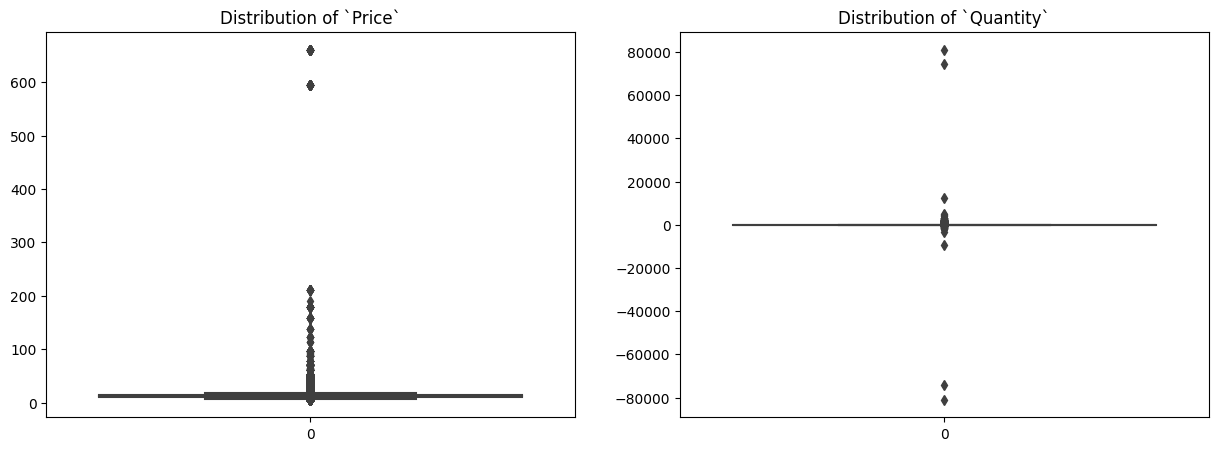

In [412]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(df['Price'], ax=ax[0])
ax[0].set_title("Distribution of `Price`")

sns.boxplot(df['Quantity'], ax=ax[1])
ax[1].set_title("Distribution of `Quantity`")

Distribution of `Price` is characterized by a high presence of outliers

We can see that the 

In [413]:
logs = np.log(df.select_dtypes([int, float]))
logs.columns = ['log'+c for c in logs.columns]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='logTotalPrice'>

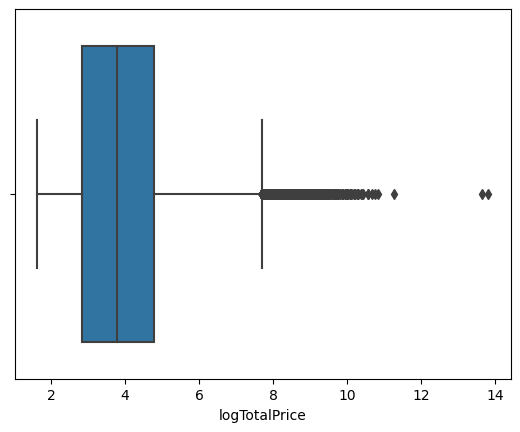

In [414]:
sns.boxplot(x=logs['logTotalPrice'])

In [415]:
# sns.regplot(logs, x='logQuantity', y='logTotalPrice')